# Emotion Recognition

My project will focus on sentiment analysis, the task is a multiclass classification task. The goal is to predict the emotions conveyed by the sentences that are given as input.

I start by importing the necessary libraries.

In [1]:
! pip install datasets accelerate nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl 

In [2]:
!pip freeze > requirements.txt

In [ ]:
# !pip install -r requirements.txt

In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string
import gensim.downloader
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset

I will be using the emotion dataset from hugging face, which I now load.

In [ ]:
dataset = load_dataset("emotion")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [ ]:
df_test = pd.DataFrame( dataset['test'] )
df_train = pd.DataFrame( dataset['train'] )

# Exploratory Data Analysis (EDA)

The next step is to do some analysis to explore the data, which includes text length distribution, label distribution and word clouds, to name a few. This is to help me get a better understanding of the dataset.

In [ ]:
print(df_test)

                                                   text  label
0     im feeling rather rotten so im not very ambiti...      0
1             im updating my blog because i feel shitty      0
2     i never make her separate from me because i do...      0
3     i left with my bouquet of red and yellow tulip...      1
4       i was feeling a little vain when i did this one      0
...                                                 ...    ...
1995  i just keep feeling like someone is being unki...      3
1996  im feeling a little cranky negative after this...      3
1997  i feel that i am useful to my people and that ...      1
1998  im feeling more comfortable with derby i feel ...      1
1999  i feel all weird when i have to meet w people ...      4

[2000 rows x 2 columns]


In [ ]:
print(df_train)

                                                    text  label
0                                i didnt feel humiliated      0
1      i can go from feeling so hopeless to so damned...      0
2       im grabbing a minute to post i feel greedy wrong      3
3      i am ever feeling nostalgic about the fireplac...      2
4                                   i am feeling grouchy      3
...                                                  ...    ...
15995  i just had a very brief time in the beanbag an...      0
15996  i am now turning and i feel pathetic that i am...      0
15997                     i feel strong and good overall      1
15998  i feel like this was such a rude comment and i...      3
15999  i know a lot but i feel so stupid because i ca...      0

[16000 rows x 2 columns]


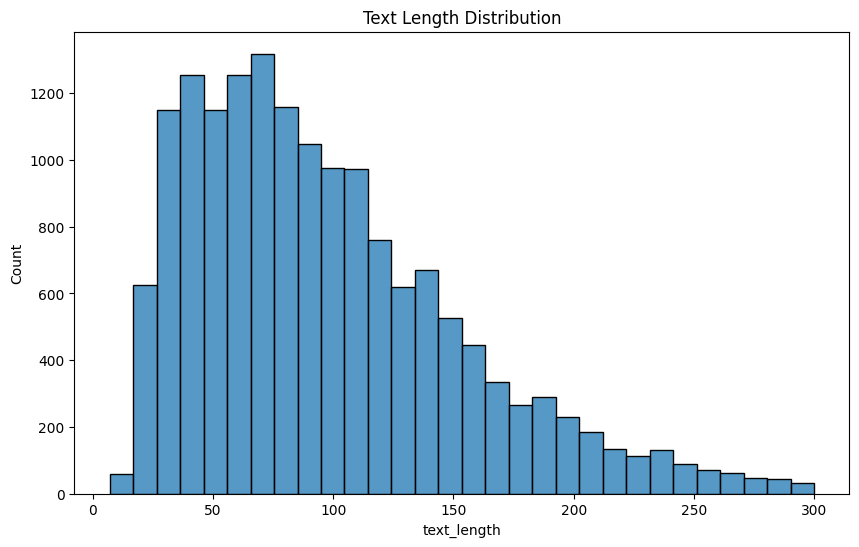

In [ ]:
# Text length distribution
df_train['text_length'] = df_train['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=30)
plt.title('Text Length Distribution')
plt.show()

In [ ]:
# Basic statistics
num_sentences = df_train.shape[0]
avg_sentence_length = df_train['text'].apply(lambda x: len(x.split())).mean()

print(f"Number of sentences: {num_sentences}")
print(f"Average sentence length: {avg_sentence_length:.2f} words")

Number of sentences: 16000
Average sentence length: 19.17 words


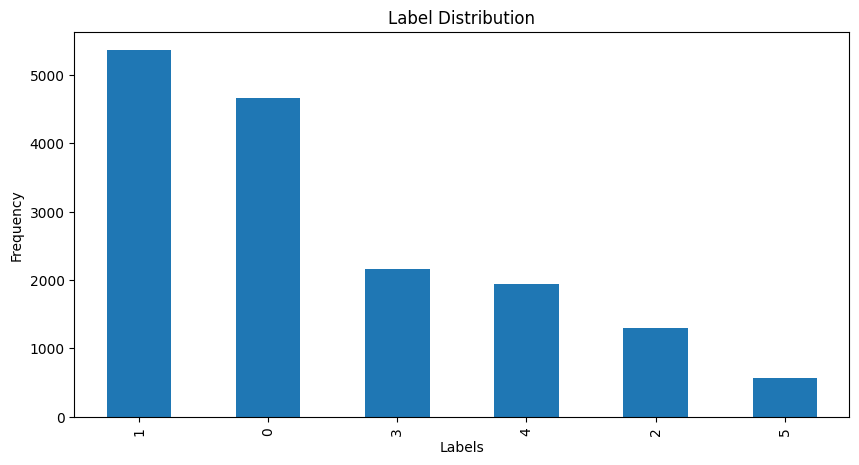

In [ ]:
# Label distribution
label_counts = df_train['label'].value_counts()

# Plotting label distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

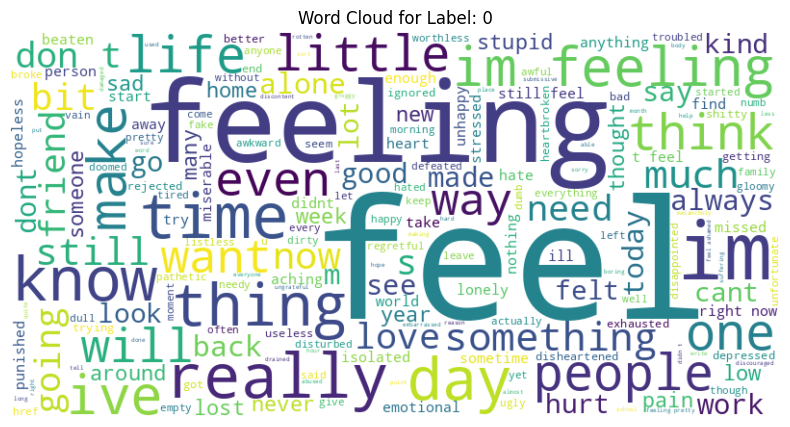

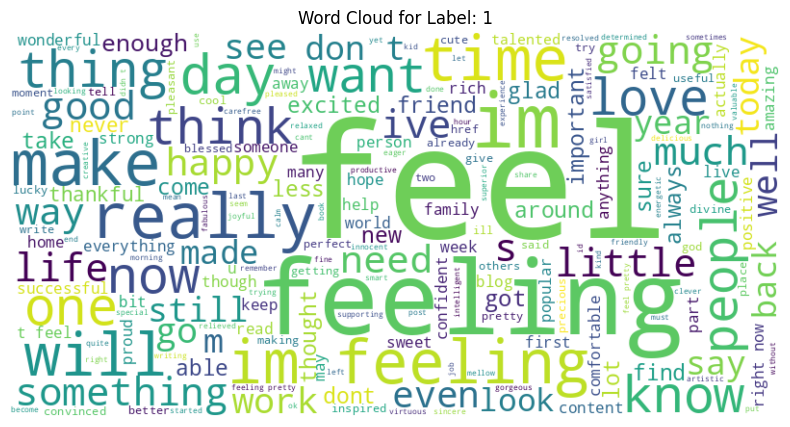

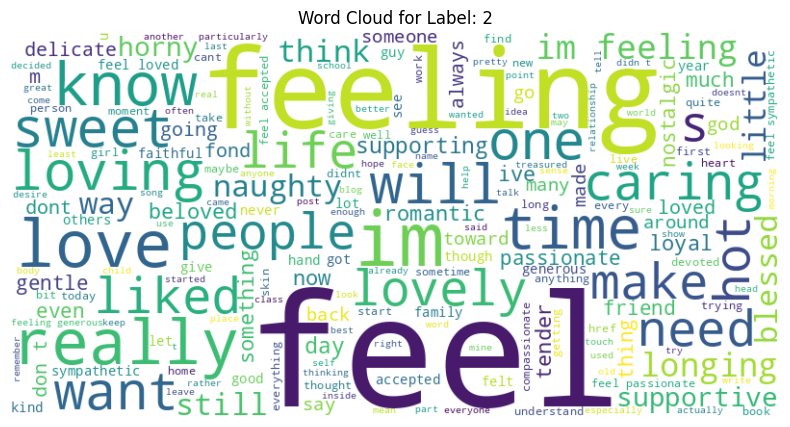

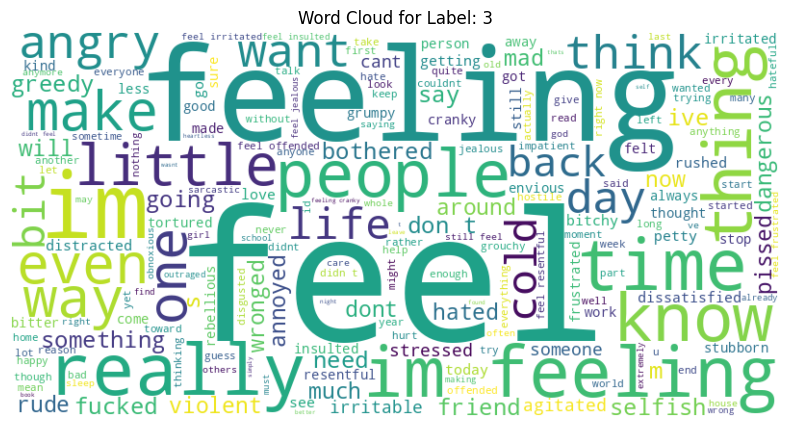

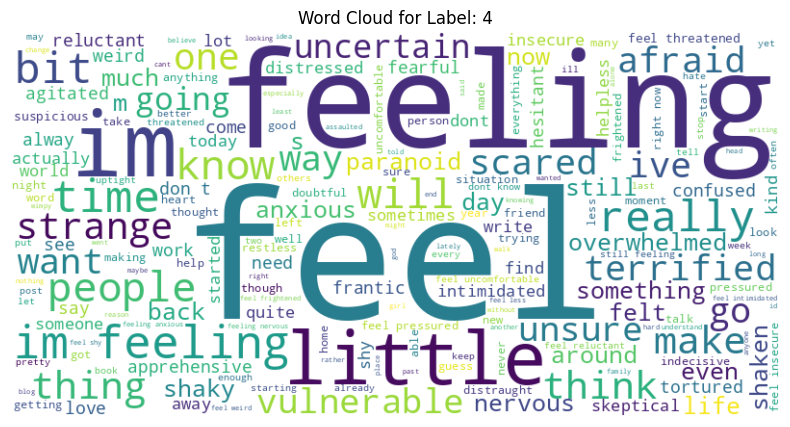

In [ ]:
# Generate word clouds for each label
for label in range(5):
    text = " ".join(df_train[df_train['label'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {label}')
    plt.axis('off')
    plt.show()

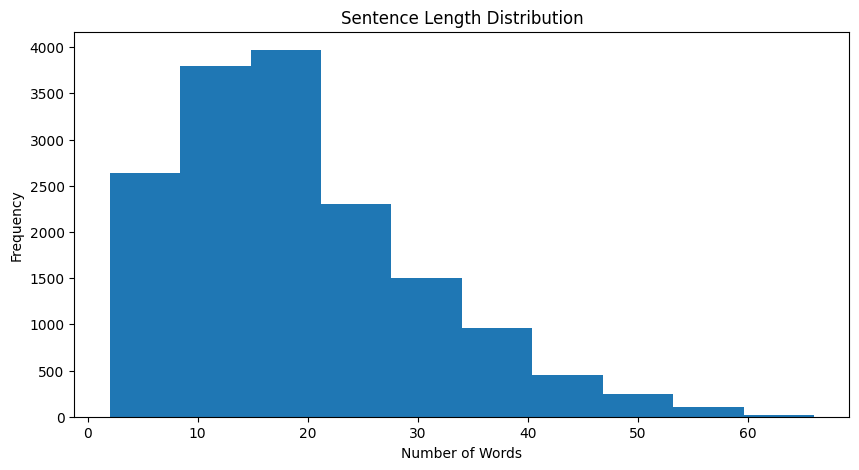

In [ ]:
# Sentence length distribution
sentence_lengths = df_train['text'].apply(lambda x: len(x.split()))

# Plotting sentence length distribution
plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths, bins=10)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Preprocessing

I then perform some preprocessing to make the data more suitable for modeling.

In [ ]:
punctuations = list(string.punctuation)
stopwords_list = list(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def nltk_tokenizer(sentence):
    # we lowercase all sentences
    sentence = sentence.lower()

    # here we tokenize it using nltk
    my_tokenized_tokens = word_tokenize(sentence)

    # lemmatization
    my_lemmatized_tokens = [lemmatizer.lemmatize(word) for word in my_tokenized_tokens]

    # Removing stop words and punctuations
    mytokens = [word for word in my_lemmatized_tokens if word not in stopwords_list and word not in punctuations]

    # return preprocessed list of tokens
    return mytokens

In [ ]:
print("apply tokenizer to test data")
df_test['tokens'] = df_test['text'].apply(nltk_tokenizer)
df_test['sentence'] =  df_test.tokens.apply(lambda x: ' '.join(x))

print("apply tokenizer to train data")
df_train['tokens'] = df_train['text'].apply(nltk_tokenizer)
df_train['sentence'] =  df_train.tokens.apply(lambda x: ' '.join(x))

apply tokenizer to test data
apply tokenizer to train data


In [ ]:
print(df_test)

                                                   text  label  \
0     im feeling rather rotten so im not very ambiti...      0   
1             im updating my blog because i feel shitty      0   
2     i never make her separate from me because i do...      0   
3     i left with my bouquet of red and yellow tulip...      1   
4       i was feeling a little vain when i did this one      0   
...                                                 ...    ...   
1995  i just keep feeling like someone is being unki...      3   
1996  im feeling a little cranky negative after this...      3   
1997  i feel that i am useful to my people and that ...      1   
1998  im feeling more comfortable with derby i feel ...      1   
1999  i feel all weird when i have to meet w people ...      4   

                                                 tokens  \
0     [im, feeling, rather, rotten, im, ambitious, r...   
1                    [im, updating, blog, feel, shitty]   
2     [never, make, separate, 

In [ ]:
print(df_train)

                                                    text  label  text_length  \
0                                i didnt feel humiliated      0           23   
1      i can go from feeling so hopeless to so damned...      0          108   
2       im grabbing a minute to post i feel greedy wrong      3           48   
3      i am ever feeling nostalgic about the fireplac...      2           92   
4                                   i am feeling grouchy      3           20   
...                                                  ...    ...          ...   
15995  i just had a very brief time in the beanbag an...      0          101   
15996  i am now turning and i feel pathetic that i am...      0          102   
15997                     i feel strong and good overall      1           30   
15998  i feel like this was such a rude comment and i...      3           59   
15999  i know a lot but i feel so stupid because i ca...      0           62   

                                       

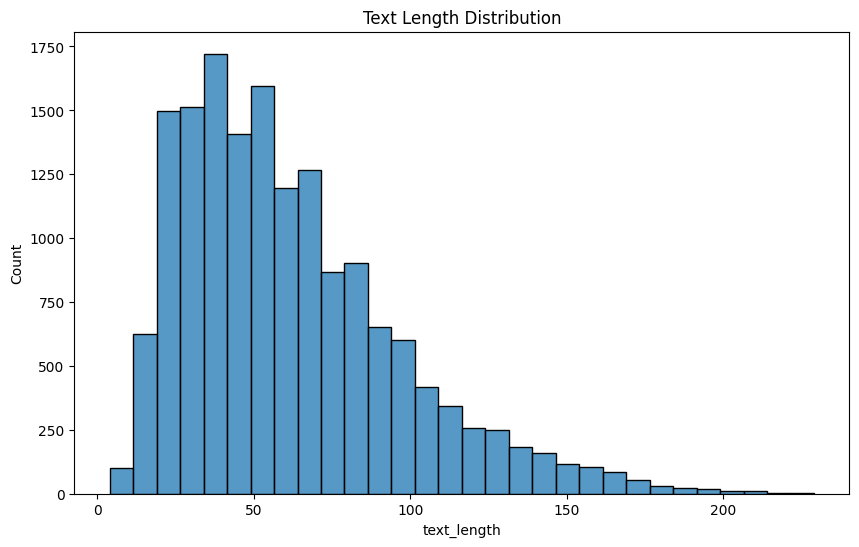

In [ ]:
# Text length distribution
df_train['text_length'] = df_train['sentence'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=30)
plt.title('Text Length Distribution')
plt.show()

# TF-IDF

I start with tf-idf for the embeddings, and then train a logistic regression model.

In [ ]:
vocab = set()
for sent in df_train['sentence']:
    for word in sent.split(" "):
        vocab.add(word.strip())

print(len(vocab))

13462


In [ ]:
documents_train = list(df_train.sentence)
documents_test = list(df_test.sentence)

#tfidf for the training data
vectorizer = CountVectorizer(lowercase=True, vocabulary=vocab)
X_count_train = vectorizer.fit_transform(documents_train)
transformer = TfidfTransformer()
X_tfidf_train = transformer.fit_transform(X_count_train)

#tfidf for the testing data
vectorizer = CountVectorizer(lowercase=True, vocabulary=vocab)
X_count_test = vectorizer.fit_transform(documents_test)
transformer = TfidfTransformer()
X_tfidf_test = transformer.fit_transform(X_count_test)

In [ ]:
Y_label_train = df_train['label'].to_list()

classifier = LogisticRegression()
classifier.fit(X_tfidf_train, Y_label_train)

y_test = df_test['label'].to_list()
predicted = classifier.predict(X_tfidf_test)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:", metrics.precision_score(y_test, predicted, average= "weighted"))
print("Logistic Regression Recall:", metrics.recall_score(y_test, predicted, average= "weighted"))

Logistic Regression Accuracy: 0.868
Logistic Regression Precision: 0.868059190729774
Logistic Regression Recall: 0.868


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Word Embeddings

I now try to do the embeddings using fast text.

In [ ]:
#pretrained_vectors = gensim.downloader.load('glove-wiki-gigaword-50')
#pretrained_vectors = gensim.downloader.load('glove-wiki-gigaword-300')
pretrained_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')
#pretrained_vectors = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def sent_vec(sent):
  vector_size = pretrained_vectors.vector_size    # value/dimension
  wv_res = np.zeros(vector_size)    # all vectors will be zeros
  # print(wv_res)
  ctr = 1
  for w in sent:    # iterate through our sentence--> w
    if w in pretrained_vectors:    # do we have that particular word present in our pretrained vectors
      ctr += 1    # we need to count them. Because for average we need to know how many in our sentences
      wv_res += pretrained_vectors.get_vector(w)    #  add vector representation of this particular word to zero vector
  wv_res =  wv_res/ctr   # evetually added all the vectors associated with each word in the sentence (of the dataset) in
  # this final vector--> wv_res....and then divide by the number of words-> ctr
  return wv_res

In [ ]:
# to get average vectors
df_train['vec'] = df_train['tokens'].apply(sent_vec)
# to get average vectors
df_test['vec'] = df_test['tokens'].apply(sent_vec)

X_train_embs = df_train['vec'].to_list()
Y_train_labels = df_train['label'].to_list()

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train_embs, Y_train_labels)

X_test_embs = df_test['vec'].to_list()
y_test_labels = df_test['label'].to_list()
predicted = classifier.predict(X_test_embs)
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test_labels, predicted))
print("Logistic Regression Precision:", metrics.precision_score(y_test_labels, predicted, average = 'weighted'))
print("Logistic Regression Recall:", metrics.recall_score(y_test_labels, predicted, average = 'weighted'))

Logistic Regression Accuracy: 0.617
Logistic Regression Precision: 0.6399567977585132
Logistic Regression Recall: 0.617


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# BERT

Now we do the embeddings and then the classification using BERT.

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dataset_encoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
dataset_encoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
batch_size = 64
logging_steps = len(dataset_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=8,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch", # eval_strategy
                                  save_strategy="epoch",
                                  disable_tqdm=False)

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["validation"])
trainer.train();

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.251047,0.914000,0.914990
2,0.498100,0.164512,0.937500,0.937135
3,0.498100,0.164289,0.938500,0.939220
4,0.107000,0.152636,0.939500,0.939467
5,0.107000,0.158486,0.937500,0.937689
6,0.067100,0.162031,0.941500,0.941413
7,0.067100,0.179602,0.940500,0.940182
8,0.042100,0.173864,0.943000,0.943043


In [ ]:
## Save the model
trainer.save_model()

#VALIDATION ACCURACY
## Training and validation accuracy
trainer.evaluate()

{'eval_loss': 0.17386429011821747,
 'eval_accuracy': 0.943,
 'eval_f1': 0.9430426955927966,
 'eval_runtime': 7.5723,
 'eval_samples_per_second': 264.12,
 'eval_steps_per_second': 4.226,
 'epoch': 8.0}

In [ ]:
# Make predictions using the trainer
predictions, labels, metrics = trainer.predict(dataset_encoded["test"])

# The `predictions` are logits, so we need to convert them to predicted labels
predicted_labels = torch.argmax(torch.tensor(predictions), axis=1)

# Define the compute_metrics function
def compute_metrics(pred):
    labels = pred[1]  # Access labels from the PredictionOutput object
    preds = pred[0]  # Get the predicted class labels
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

results = compute_metrics((predicted_labels.numpy(), labels))

print(results)

{'accuracy': 0.9215, 'f1': 0.9217687837948348}


In [ ]:
# Define the sample sentences and their true labels
sample_sentences = [
    "I can't believe my dog passed away.",  # sadness
    "I feel so happy at home!",             # joy
    "I cherish every moment with you.",     # love
    "He yelled at me for no reason.",       # anger
    "I'm afraid of walking alone at night.",# fear
    "I'm really shocked by the news!"       # surprise
    ]

# Examples of sentences associated with love and surprise

# Assume these are the true labels for the sample sentences
true_labels = ['sadness','joy', 'love', 'anger', 'fear', 'surprise']


In [ ]:
# Tokenize the sample sentences
sample_encodings = tokenizer(sample_sentences, truncation=True, padding=True, return_tensors='pt')

In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Move input tensors to the same device as the model
sample_encodings= {k: v.to(device) for k, v in sample_encodings.items()}

In [ ]:
with torch.no_grad():
    model.eval()
    outputs = model(**sample_encodings)
    logits = outputs.logits

# Get the predicted labels
predicted_indices = torch.argmax(logits, axis=1).tolist()

In [ ]:
# Map indices to label names
label_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
predicted_labels = [label_map[i] for i in predicted_indices]

# Print the predicted labels
print("Predicted Labels:", predicted_labels)

# Compute accuracy (if true labels are available)
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the accuracy
print("Accuracy:", accuracy)

Predicted Labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Accuracy: 1.0
